# Ranking Education, Police and Sanitation by district of operation

The metrics we are going to use:
- Median and mean complaint resolution time.
- Number of complaints normalized by population. Note that there is no data about the population of the districts of operation, which are not related to NTAs, so we approximate it by a weighted sum of the population of the NTAs overlapping with the district.

In [119]:
import pandas as pd
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly
import json
import numpy as np
%matplotlib inline
import warnings

In [93]:
df_311 = pd.read_pickle("data/311_Service_Requests_from_2010_to_Present_small.pkl")
df_311.set_index("Unique Key")
relevant_columns = ["Created Date", "Closed Date", "Agency", "Complaint Type", "Latitude", "Longitude"]
df_311 = df_311[relevant_columns]
df_311.to_pickle("data/ranking_departments.pkl")

In [96]:
count_by_agency = df_311.groupby("Agency").count()["Created Date"]

In [169]:
name_mapping = {"NYPD": "Police Department", "HPD": "Housing Preservation & Development",
                "DOT": "Department of Transportation", "DSNY": "Sanitation Department",
                "DEP": "Department of Environmental Protection Police"}
count_by_agency = count_by_agency.sort_values(ascending=False).rename(name_mapping)
count_by_agency = count_by_agency / count_by_agency.sum()

In [170]:
layout = go.Layout(
    yaxis = go.layout.YAxis(
        tickformat = '%'
    )
)
fig = go.Figure(
    data=go.Bar(x=count_by_agency.keys()[:5], y=count_by_agency.values[:5],
        marker=dict(
        color='rgb(250,128,114)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
        text=count_by_agency.values[:5].round(2),
        textposition = 'auto',
        opacity=0.6),
    layout=layout,
    layout_title_text="Percentage of 3-1-1 calls by agency"
)
fig.update_layout(template="plotly_dark")
plotly.offline.plot(fig, filename='.html')

'.html'

In [146]:
df_nta_population = pd.read_csv(
    "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv")[["NTA Code", "Population"]].set_index("NTA Code")

In [5]:
# load GeoJSON file containing districts and create polygons
nta_geojson = "data/Neighborhood Tabulation Areas.geojson"
nta_id_field = "ntacode"
doe_geojson = "data/School Districts.geojson"
doe_id_field = "school_dist"
nypd_geojson = "data/Police Precincts.geojson"
nypd_id_field = "precinct"
fdny_geojson = "data/Fire Battalions.geojson"
fdny_id_field = "fire_bn"
dsny_geojson = "data/DSNY Districts.geojson"
dsny_id_field = "districtcode"
def get_polygons(geojson_path, id_field):
    with open(geojson_path) as f:
        js = json.load(f)
        return [(feature["properties"][id_field], shape(feature["geometry"])) for feature in js["features"]]

def get_district(row, polygons):
    """Retrieves the district of a given location in NYC.
    Args:
        row: 311 request with associated metadata (e.g. location)
    Returns:
        String: code of the district the location is part of, or NaN if the location is not within a district
    """
    longitude = row["Longitude"]
    latitude = row["Latitude"]
    point = Point(longitude, latitude)
    for polygon in polygons:
        if polygon[1].contains(point):
            district_code = polygon[0]
            return district_code
    return np.nan

In [6]:
# split into agencies and use only those with present latitude and longitude
df_311 = df_311[df_311["Latitude"].notnull() & df_311["Longitude"].notnull()]
df_nypd = df_311[df_311["Agency"] == "NYPD"].drop(columns="Agency")
df_dsny = df_311[df_311["Agency"] == "DSNY"].drop(columns="Agency")
df_fdny = df_311[df_311["Agency"] == "FDNY"].drop(columns="Agency")
df_doe = df_311[df_311["Agency"] == "DOE"].drop(columns="Agency")

In [10]:
agencies = [(df_doe, doe_geojson, doe_id_field, []),
           (df_nypd, nypd_geojson, nypd_id_field, []),
           (df_dsny, dsny_geojson, dsny_id_field, []),
           (df_fdny, fdny_geojson, fdny_id_field, [])]

In [13]:
for agency in agencies:
    print(len(agency[0]))

18133
5097994
1832606
58


We realize that we few complaints from Fire Departments with specified location so we drop it.
There are also not many such complaints to the department of education (~19k) and we also decide not to use if further.

In [16]:
agencies = [agencies[i] for i in [1,2]]

In [17]:
for agency in agencies:
    polygons = get_polygons(agency[1], agency[2])
    agency[0]["District"] = agency[0].apply(lambda x: get_district(x, polygons), axis=1)

In [18]:
nta_pop_df = pd.read_csv("data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv")

In [19]:
# the census is done every 10 years, so we have to depend on the 2010 data
nta_pop_df = nta_pop_df[nta_pop_df["Year"] == 2010][["NTA Code", "Population"]].set_index("NTA Code")

In [20]:
# Get estimated population of each district. We drop the three districts that have ill defined boundaries.
nta_polygons = get_polygons(nta_geojson, nta_id_field)
for agency in agencies:
    polygons = get_polygons(agency[1], agency[2])
    agency[3].clear()
    for polygon in polygons:
        district_population = 0
        district_failed = False
        for nta_polygon in nta_polygons:
            try:
                district_population += (nta_polygon[1].intersection(polygon[1]).area / nta_polygon[1].area) * \
                    nta_pop_df[nta_pop_df.index == nta_polygon[0]].values[0][0]
            except:
                print(f"failed for nta: {nta_polygon[0]} with district {polygon[0]}")
                district_failed = True
                break
        if district_failed:
            continue
        agency[3].append((polygon[0], district_population))

TopologyException: Input geom 1 is invalid: Too few points in geometry component at or near point -73.905913525222076 40.587544309958552 at -73.905913525222076 40.587544309958552


failed for nta: QN10 with district 61


In [21]:
agencies_df = [agency[0] for agency in agencies]
for i, agency in enumerate(agencies):
    time_diff = agencies_df[i]["Closed Date"] - agencies_df[i]["Created Date"]
    agencies_df[i]["Resolution Time (days)"] = time_diff.apply(lambda x: x.total_seconds() / (24 * 3600))

In [22]:
for agency in agencies_df:
    agency.rename(columns={"Resolution Time": "Resolution Time (days)"}, inplace=True)

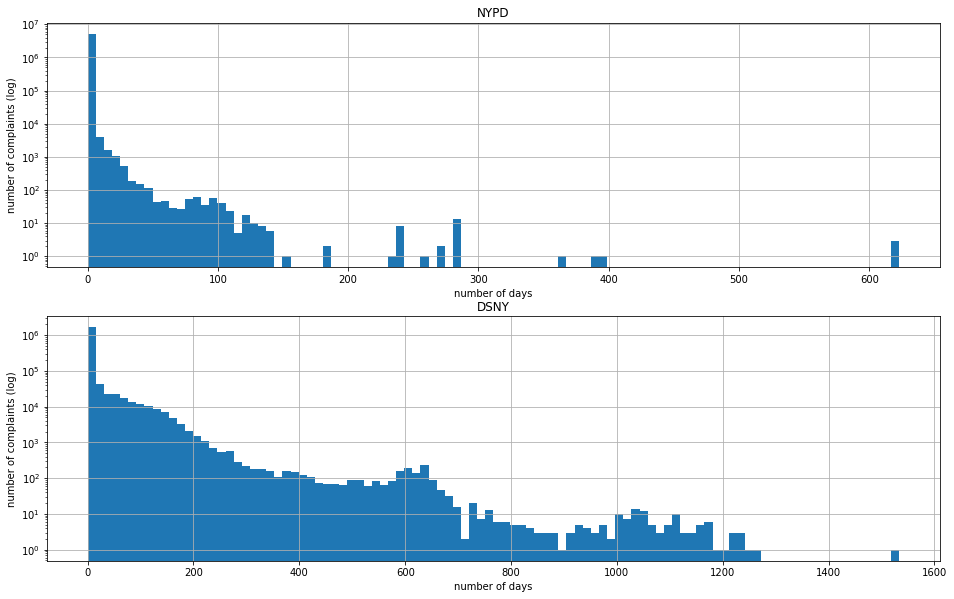

In [26]:
agency_names = ["NYPD", "DSNY"]
f, axes = plt.subplots(2, figsize=(16,9))
plt.subplots_adjust(bottom=0.05)
for i in range(2):
    axes[i].set_yscale("log")
    agencies_df[i]["Resolution Time (days)"].hist(ax=axes[i], bins=100)
    axes[i].set_title(agency_names[i])
    axes[i].set_ylabel("number of complaints (log)")
    axes[i].set_xlabel("number of days")

It appears that there are outliers in case of NYPD and DSNY. Histogram of the Department of Education shows unexpected spike around 1200 - 1400 days. We decide to keep those entries as they are most likely valid.

In [27]:
print("Most common call categories\n")
for i, agency in enumerate(agencies_df):
    print(agency_names[i])
    print(agency.groupby("Complaint Type").agg("size").sort_values(ascending=False).head(10))
    print()

Most common call categories

NYPD
Complaint Type
Noise - Residential            1762451
Blocked Driveway                891486
Illegal Parking                 871447
Noise - Street/Sidewalk         459908
Noise - Commercial              341325
Noise - Vehicle                 209198
Derelict Vehicle                206187
Non-Emergency Police Matter      66316
Animal Abuse                     51999
Vending                          41218
dtype: int64

DSNY
Complaint Type
Dirty Conditions                       334757
Request Large Bulky Item Collection    325106
Sanitation Condition                   288091
Missed Collection (All Materials)      250855
Derelict Vehicles                      197538
Graffiti                               153017
Snow                                    75624
Other Enforcement                       57148
Electronics Waste Appointment           32624
Electronics Waste                       26473
dtype: int64



We realize that even though the calls are supposedly complaints, they cannot always be classified as such. This is the case for many of the DSNY calls as it appears to be receiving regular requests for garbage collection through 311. 

In [28]:
agencies_df[1].groupby("Complaint Type").agg("size").sort_values(ascending=False).head(30)

Complaint Type
Dirty Conditions                       334757
Request Large Bulky Item Collection    325106
Sanitation Condition                   288091
Missed Collection (All Materials)      250855
Derelict Vehicles                      197538
Graffiti                               153017
Snow                                    75624
Other Enforcement                       57148
Electronics Waste Appointment           32624
Electronics Waste                       26473
Litter Basket / Request                 24845
Vacant Lot                              17176
Derelict Bicycle                        12770
Overflowing Litter Baskets              10715
Recycling Enforcement                    8408
Sweeping/Missed                          5649
Sweeping/Missed-Inadequate               5490
Request Xmas Tree Collection             1936
Sweeping/Inadequate                      1782
Collection Truck Noise                   1498
Adopt-A-Basket                            555
Missed Collection  

We decide to drop the calls categorized as:
- Request Large Bulky Item Collection
- Electronics Waste Appointment
- Electronics Waste
- Litter Basket / Request
- Request Xmas Tree Collection
- Adopt-A-Basket

In [29]:
agencies_df[1] = agencies_df[1][~agencies_df[1]["Complaint Type"].isin([
    "Adopt-A-Basket", "Request Xmas Tree Collection", "Litter Basket / Request", "Electronics Waste",
    "Electronics Waste Appointment", "Request Large Bulky Item Collection"
])]

In [30]:
for i, agency in enumerate(agencies_df):
    print(f"{agency_names[i]} entries: {len(agency)}")
    print("NaNs:")
    print(agency.isna().sum())
    print()

NYPD entries: 5097994
NaNs:
Created Date                 0
Closed Date               5126
Complaint Type               0
Latitude                     0
Longitude                    0
District                   483
Resolution Time (days)    5126
dtype: int64

DSNY entries: 1421067
NaNs:
Created Date                  0
Closed Date               14870
Complaint Type                0
Latitude                      0
Longitude                     0
District                   2139
Resolution Time (days)    14870
dtype: int64



We decide to drop the NaNs as they are a small minority of the calls.

In [43]:
for agency in agencies_df:
    agency.dropna(inplace=True)
    warnings.simplefilter("ignore")
    agency["Created Year"] = agency["Created Date"].apply(lambda x: x.year)

In [62]:
agency

,Created Date,Closed Date,Complaint Type,Latitude,Longitude,District,Resolution Time (days),Created Year
0,2016-01-17 22:12:35,2016-01-17 23:14:02,Noise - Residential,40.861404,-73.903217,52,0.042674,2016
1,2016-01-17 15:23:56,2016-01-17 19:28:40,Noise - Residential,40.841828,-73.937822,33,0.169954,2016
3,2016-01-17 18:46:31,2016-01-17 19:51:41,Noise - Commercial,40.651177,-73.941618,67,0.045255,2016
4,2016-01-18 00:02:23,2016-01-18 16:51:22,Noise - Residential,40.636969,-73.958533,70,0.700683,2016
5,2016-01-17 20:36:41,2016-01-17 21:38:22,Noise - Residential,40.846214,-73.905618,46,0.042836,2016
...,...,...,...,...,...,...,...,...
21741898,2016-01-17 23:27:08,2016-01-18 02:53:34,Noise - Commercial,40.651177,-73.941618,67,0.143356,2016
21741899,2016-01-17 22:24:59,2016-01-18 00:15:18,Noise - Commercial,40.695032,-73.828497,102,0.076609,2016
21741900,2016-01-17 22:53:07,2016-01-18 00:19:40,Noise - Commercial,40.678394,-73.948271,77,0.060104,2016
21741901,2016-01-17 16:55:01,2016-01-17 18:20:35,Noise - Commercial,40.702116,-73.810623,103,0.059421,2016


In [70]:
grouped_agencies = []
rank = False
for i, agency in enumerate(agencies_df):
    grouped_agencies.append(agency.groupby(["District", "Created Year"])["Resolution Time (days)"].agg(["mean", "median", "count"])
                            .rename(columns={"median": "Median resolution time (days)",
                                             "mean": "Mean resolution time (days)",
                                             "count": "Number of complaints"}))
    district_population = pd.DataFrame(agencies[i][3]).set_index(0)
    grouped_agencies[i] = grouped_agencies[i].join(district_population, on="District").rename(columns={1: "District population"})
    # drop districts with very small number of inhabitants. As previously noted those are often parks
    grouped_agencies[i] = grouped_agencies[i][grouped_agencies[i]["District population"] > 10000]
    
    grouped_agencies[i]["Complaints per 1k capita"] = \
        1000 * grouped_agencies[i]["Number of complaints"] / grouped_agencies[i]["District population"]
    grouped_agencies[i].sort_values("Complaints per 1k capita", inplace=True)
    
    if rank:
        grouped_agencies[i]["Mean resolution time rank"] = grouped_agencies[i]["Mean resolution time (days)"].rank()
        grouped_agencies[i]["Median resolution time rank"] = grouped_agencies[i]["Median resolution time (days)"].rank(method="first")
        grouped_agencies[i]["Number of complaints rank"] = grouped_agencies[i]["Number of complaints"].rank(method="first")
        grouped_agencies[i]["Complaints per 1k capita rank"] = grouped_agencies[i]["Complaints per 1k capita"].rank(method="first")

We decide to use two metrics for ranking the agencies in districts: complaints per capita and the median resolution time. As we have seen in the histogram with resolution time, there are present outliers in the dataset and median is more robust to outliers than the mean.

In [114]:
print(agency_names[1])
# we create a value for complaints per capita in the range (0, 1), where 0 means 0 and 1 means 50 per 1k capita
grouped_agencies[1]["Complaints per capita norm"] = grouped_agencies[1]["Complaints per 1k capita"] / 50
# similarly for median resolution time in days, 1 meaning 10 days
grouped_agencies[1]["Median resolution time (days) norm"] = grouped_agencies[1]["Median resolution time (days)"] / 10
grouped_agencies[1].to_pickle("data/dsny_ranking.pkl")
grouped_agencies[1]

DSNY


,,Mean resolution time (days),Median resolution time (days),Number of complaints,District population,Complaints per 1k capita,Complaints per capita norm,Median resolution time (hours),Median resolution time (hours) norm,Median resolution time (days) norm
District,Created Year,,,,,,,,,
107,2012,3.901260,1.145833,861,200571.338371,4.292737,0.085855,27.500000,1.833333,0.114583
205,2013,28.205429,1.938542,524,120788.208561,4.338172,0.086763,46.525000,3.101667,0.193854
109,2012,10.774949,1.947222,505,113264.247086,4.458600,0.089172,46.733333,3.115556,0.194722
108,2012,7.823667,1.172222,1103,219020.148785,5.036066,0.100721,28.133333,1.875556,0.117222
109,2013,16.240500,2.930556,594,113264.247086,5.244373,0.104887,70.333333,4.688889,0.293056
...,...,...,...,...,...,...,...,...,...,...
305,2018,9.365523,0.902083,6992,161010.237204,43.425810,0.868516,21.650000,1.443333,0.090208
412,2018,6.249086,1.134722,9855,226720.063100,43.467701,0.869354,27.233333,1.815556,0.113472
306,2016,8.268647,1.884028,4374,100470.181863,43.535305,0.870706,45.216667,3.014444,0.188403


In [92]:
print(agency_names[0])
# we create a value for complaints per capita in the range (0, 1), where 0 means 0 and 1 means ~200 per 1k capita
grouped_agencies[0]["Complaints per capita norm"] = grouped_agencies[0]["Complaints per 1k capita"] / 201
grouped_agencies[0]["Median resolution time (hours)"] = grouped_agencies[0]["Median resolution time (days)"] * 24
# similarly for median resolution time in hours, 1 meaning 15 hours
grouped_agencies[0]["Median resolution time (hours) norm"] = grouped_agencies[0]["Median resolution time (hours)"] / 15
grouped_agencies[0].to_pickle("data/nypd_ranking.pkl")
grouped_agencies[0]

NYPD


Mean resolution time (days)  \
District Created Year                                
123      2012                             0.134790   
101      2012                             0.106771   
111      2012                             0.112168   
123      2011                             0.131435   
111      2011                             0.094371   
...                                            ...   
34       2017                             1.636961   
30       2018                             0.107177   
         2017                             0.091979   
88       2016                             1.233394   
34       2018                             0.477241   

                       Median resolution time (days)  Number of complaints  \
District Created Year                                                        
123      2012                               0.095457                  1748   
101      2012                               0.073218                  1153   
111      2012                               0.081383                  2002   
123      2011                               0.094444                  1825   
111      2011                               0.069172                  2036   
...                                              ...                   ...   
34       2017                               0.235718                 20242   
30       2018                               0.059711                 10037   
         2017                               0.070833                 10153   
88       2016                               0.119317                  9655   
34       2018                               0.160845                 22163   

                       District population  Complaints per 1k capita  \
District Created Year                                                  
123      2012                104936.888290                 16.657631   
101      2012                 68240.982442                 16.896005   
111      2012                116994.866595                 17.111862   
123      2011                104936.888290                 17.391406   
111      2011                116994.866595                 17.402473   
...                                    ...                       ...   
34       2017                110307.835909                183.504643   
30       2018                 54337.153419                184.717074   
         2017                 54337.153419                186.851893   
88       2016                 50802.992302                190.047861   
34       2018                110307.835909                200.919543   

                       Complaints per capita norm  \
District Created Year                               
123      2012                            0.082874   
101      2012                            0.084060   
111      2012                            0.085134   
123      2011                            0.086524   
111      2011                            0.086579   
...                                           ...   
34       2017                            0.912958   
30       2018                            0.918990   
         2017                            0.929611   
88       2016                            0.945512   
34       2018                            0.999600   

                       Median resolution time (hours)  \
District Created Year                                   
123      2012                                2.290972   
101      2012                                1.757222   
111      2012                                1.953194   
123      2011                                2.266667   
111      2011                                1.660139   
...                                               ...   
34       2017                                5.657222   
30       2018                                1.433056   
         2017                                1.700000   
88       2016                                2.8636

In [112]:
grouped_agencies[1]["Median resolution time (days)"].max()

9.901388888888889

In [113]:
grouped_agencies[1]["Median resolution time (days)"].min()

0.4527777777777778